# Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
real_photos_path = '/content/drive/MyDrive/Colab Notebooks/real'
fake_photos_path = '/content/drive/MyDrive/Colab Notebooks/fake'

In [1]:
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import glob
from PIL import Image

In [2]:
from sklearn.metrics import classification_report
from sklearn import svm

In [4]:
def read_images(folder_path):
    images = []
    files = '*.*'
    image_files = glob.glob(folder_path + '/' + files)
    for file in image_files:
        try:
            image = Image.open(file)
        except:
            continue
        images.append(image)
    return images

In [5]:
real_images = read_images(real_photos_path)
fake_images = read_images(fake_photos_path)

In [6]:
len(real_images), len(fake_images)

(1708, 1710)

In [7]:
def plot_real_fake_image(real_images, fake_images):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(real_images[0])
    plt.title('real')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(fake_images[0])
    plt.title('fake')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

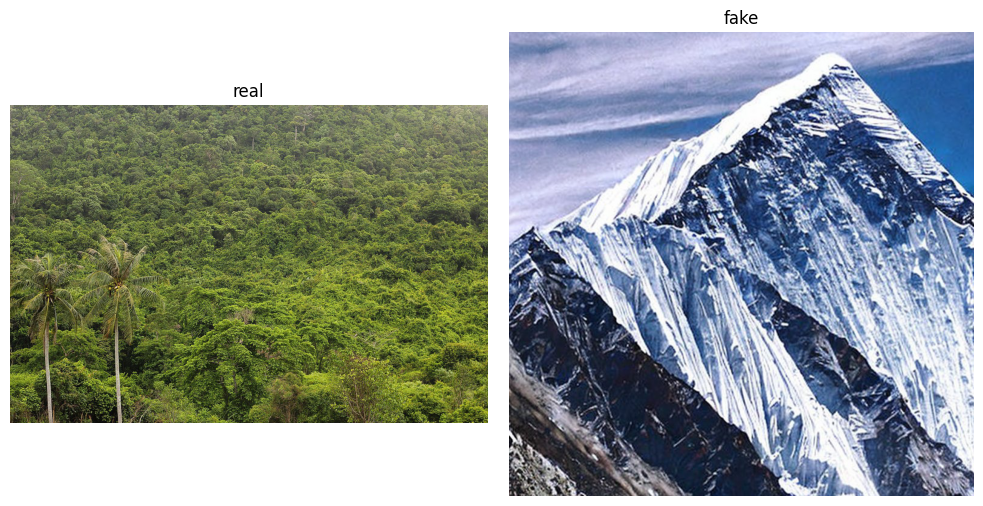

In [8]:
plot_real_fake_image(real_images, fake_images)

# Extract Naive Features

In [10]:
import gc, sys
def extract_RGB_features(images_path):
    i = 0
    files = '*.*'
    RGB_features = []
    image_files = glob.glob(images_path + '/' + files)
    for file in image_files:
        try:
            image = cv2.imread(file)
            if (len(image.shape) != 3):
                raise RuntimeError()
            mean_rgb = np.mean(image, axis=(0, 1))
            std_rgb = np.std(image, axis=(0, 1))
            percentiles = np.percentile(image, q=[10, 20, 30, 40, 50, 60, 70, 80, 90], axis=(0, 1))
            RGB_features.append(list(mean_rgb)+list(std_rgb)+list(percentiles))
            print('\b'*22, end='')
            print(f'Completed {i} images', end='')
            i += 1
        except:
            continue
    return RGB_features

In [11]:
real_naive_features = extract_RGB_features(real_photos_path)
fake_naive_features = extract_RGB_features(fake_photos_path)

Completed 0 imagesCompleted 1 imagesCompleted 2 imagesCompleted 3 imagesCompleted 4 imagesCompleted 5 imagesCompleted 6 imagesCompleted 7 imagesCompleted 8 imagesCompleted 9 imagesCompleted 10 imagesCompleted 11 imagesCompleted 12 imagesCompleted 13 imagesCompleted 14 imagesCompleted 15 imagesCompleted 16 imagesCompleted 17 imagesCompleted 18 imagesCompleted 19 imagesCompleted 20 imagesCompleted 21 imagesCompleted 22 imagesCompleted 23 imagesComp

In [27]:
real_naive_features.shape, fake_naive_features.shape

((1707, 33), (1710, 33))

In [28]:
naive_features = np.vstack((real_naive_features, fake_naive_features))
naive_features.shape

(3417, 33)

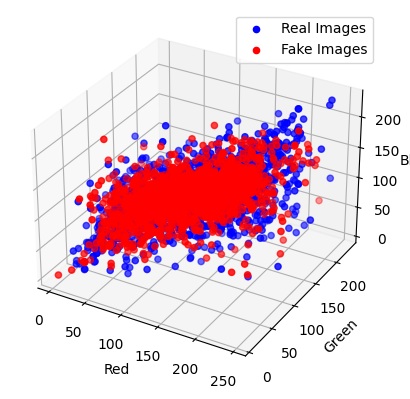

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
real_r, real_g, real_b = zip(*real_naive_features[:,:3])
ax.scatter(real_r, real_g, real_b, c='blue', label='Real Images')
fake_r, fake_g, fake_b = zip(*fake_naive_features[:,:3])
ax.scatter(fake_r, fake_g, fake_b, c='red', label='Fake Images')
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.legend()
plt.show()

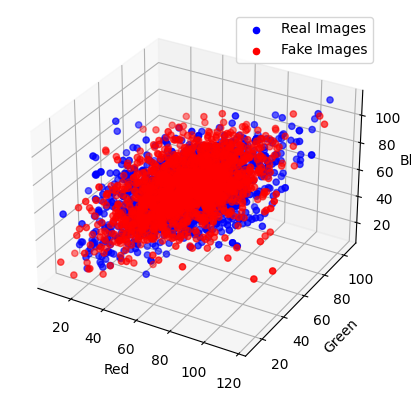

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
real_r, real_g, real_b = zip(*real_naive_features[:,3:6])
ax.scatter(real_r, real_g, real_b, c='blue', label='Real Images')
fake_r, fake_g, fake_b = zip(*fake_naive_features[:,3:6])
ax.scatter(fake_r, fake_g, fake_b, c='red', label='Fake Images')
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.legend()
plt.show()

# Classification With Naive Features

In [9]:
from sklearn.model_selection import GridSearchCV

def grid_search_best_svm(X_train, y_train, cv=10):
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}

    grid = GridSearchCV(svm.SVC(), param_grid, cv=cv, verbose=3)
    grid.fit(X_train, y_train)
    return grid

In [10]:
data = np.genfromtxt('/content/RGB_Mean_Std_Percentile.csv', delimiter=',')
X = data[:, :-1]
y = data[:, -1]
X.shape, y.shape

((3417, 33), (3417,))

In [33]:
X = naive_features.copy()
y = np.array([1]*real_naive_features.shape[0]+[0]*fake_naive_features.shape[0])
X.shape, y.shape

((3417, 33), (3417,))

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
from sklearn.metrics import classification_report

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
grid = grid_search_best_svm(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.508 total time=   0.3s
[CV 2/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.3s
[CV 3/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.3s
[CV 4/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.3s
[CV 5/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.3s
[CV 6/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.3s
[CV 7/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.3s
[CV 8/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.3s
[CV 9/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.3s
[CV 10/10] END ......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.3s
[CV 1/10] END .....C=0.1, gamma=0.1, kernel=rbf;, score=0.508 total time=   0.3s
[CV 2/10] END .....C=0.1, gamma=0.1, kernel=rb

In [41]:
np.savetxt('RGB_Mean_Std_Percentile_2.csv', np.hstack((X, y.reshape(-1, 1))), delimiter=',')

In [39]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.0001)


In [40]:
print('Train:', '-'*70, sep='\n')
print(classification_report(y_train, grid.predict(X_train)))
print('Test:', '-'*70, sep='\n')
print(classification_report(y_test, grid.predict(X_test)))

Train:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1220
           1       0.96      0.95      0.96      1171

    accuracy                           0.96      2391
   macro avg       0.96      0.96      0.96      2391
weighted avg       0.96      0.96      0.96      2391

Test:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.61      0.60       490
           1       0.63      0.59      0.61       536

    accuracy                           0.60      1026
   macro avg       0.60      0.60      0.60      1026
weighted avg       0.60      0.60      0.60      1026



# Preprocessing

In [14]:
def preprocess_images(image_list, target_size=(300, 300), normalize=True):
    for i in range(len(image_list)):
        image_list[i] = image_list[i].resize(target_size)
        if normalize:
            image_list[i] = np.array(image_list[i]) / 255.0
        print('\b'*22, end='')
        print(f'Completed {i} images', end='')
    return image_list

In [15]:
preprocessed_real_images = preprocess_images(real_images)
preprocessed_fake_images = preprocess_images(fake_images)

Completed 0 imagesCompleted 1 imagesCompleted 2 imagesCompleted 3 imagesCompleted 4 imagesCompleted 5 imagesCompleted 6 imagesCompleted 7 imagesCompleted 8 imagesCompleted 9 imagesCompleted 10 imagesCompleted 11 imagesCompleted 12 imagesCompleted 13 imagesCompleted 14 imagesCompleted 15 imagesCompleted 16 imagesCompleted 17 imagesCompleted 18 imagesCompleted 19 imagesCompleted 20 imagesCompleted 21 imagesCompleted 22 imagesCompleted 23 imagesComp

In [16]:
len(preprocessed_real_images), len(preprocessed_fake_images)

(1708, 1710)

In [17]:
del preprocessed_real_images[1686]

In [18]:
len(preprocessed_real_images), len(preprocessed_fake_images)

(1707, 1710)

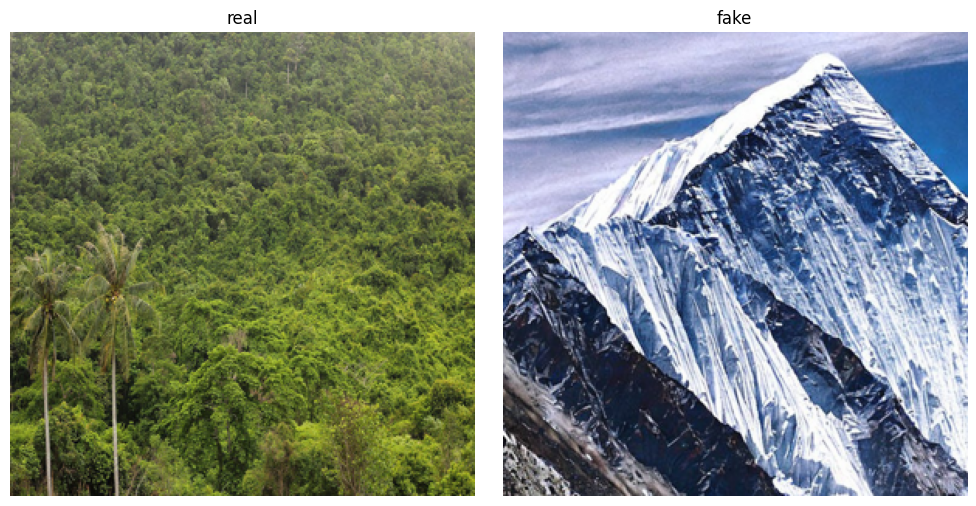

In [19]:
plot_real_fake_image(preprocessed_real_images, preprocessed_fake_images)

In [20]:
from skimage import feature

def extract_features(images, method='hog'):
    features = []
    assert method in ['hog', 'sift']
    if method == 'hog':
        for image in images:
            img_array = np.array(image)
            img_array = img_array.reshape((img_array.shape[0], img_array.shape[1], -1))
            hog_features = feature.hog(img_array, orientations=13, pixels_per_cell=(8, 8),
                                       cells_per_block=(2, 2), transform_sqrt=False,
                                       block_norm='L2-Hys', visualize=False, channel_axis=-1)
            features.append(hog_features)

    # elif method == 'sift':
    #     sift = cv2.SIFT_create()
    #     for image in images:
    #         img_array = np.array(image)
    #         gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    #         _, sift_features = sift.detectAndCompute(gray, None)
    #         features.append(sift_features)

    return features

In [21]:
real_features = extract_features(preprocessed_real_images)
fake_features = extract_features(preprocessed_fake_images)

In [22]:
real = np.stack(real_features)
fake = np.stack(fake_features)

In [23]:
real.shape, fake.shape

((1707, 67392), (1710, 67392))

In [24]:
y_real = [1]*real.shape[0]
y_fake = [0]*fake.shape[0]
y_hog = np.vstack((np.array(y_real).reshape(-1, 1), np.array(y_fake).reshape(-1, 1)))
y_hog.shape

(3417, 1)

In [25]:
X_hog = np.vstack((real, fake))
X_hog.shape

(3417, 67392)

# Classification

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
from sklearn import svm

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_hog, y_hog, test_size=0.3, random_state=42)

In [32]:
y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2391, 67392), (1026, 67392), (2391,), (1026,))

In [34]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [35]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [36]:
y_pred_train.shape, y_pred_test.shape

((2391,), (1026,))

In [37]:
print('Train:', '-'*70, sep='\n')
print(classification_report(y_train, y_pred_train))
print('Test:', '-'*70, sep='\n')
print(classification_report(y_test, y_pred_test))

Train:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1220
           1       0.97      0.98      0.98      1171

    accuracy                           0.98      2391
   macro avg       0.98      0.98      0.98      2391
weighted avg       0.98      0.98      0.98      2391

Test:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       490
           1       0.73      0.74      0.74       536

    accuracy                           0.72      1026
   macro avg       0.72      0.72      0.72      1026
weighted avg       0.72      0.72      0.72      1026



In [39]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_hog_centered = scale(X_hog, axis=0, with_mean=True, with_std=False)
pca.fit(X_hog_centered)
X_pca = pca.transform(X_hog_centered)
X_pca.shape

(3417, 100)

# Concatenating Naive Features and top 100 PCs of HOG Features

In [ ]:
X_combined = np.hstack((X, X_pca))
X_combined.shape

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

In [49]:
grid = grid_search_best_svm(X_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.508 total time=   0.5s
[CV 2/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.5s
[CV 3/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.5s
[CV 4/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.5s
[CV 5/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.5s
[CV 6/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.5s
[CV 7/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.5s
[CV 8/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.5s
[CV 9/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.5s
[CV 10/10] END ......C=0.1, gamma=1, kernel=rbf;, score=0.510 total time=   0.5s
[CV 1/10] END .....C=0.1, gamma=0.1, kernel=rbf;, score=0.508 total time=   0.5s
[CV 2/10] END .....C=0.1, gamma=0.1, kernel=rb

In [50]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.0001)


In [51]:
print('Train:', '-'*70, sep='\n')
print(classification_report(y_train, grid.predict(X_train)))
print('Test:', '-'*70, sep='\n')
print(classification_report(y_test, grid.predict(X_test)))

Train:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1220
         1.0       0.98      0.98      0.98      1171

    accuracy                           0.98      2391
   macro avg       0.98      0.98      0.98      2391
weighted avg       0.98      0.98      0.98      2391

Test:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.62      0.67      0.64       490
         1.0       0.67      0.63      0.65       536

    accuracy                           0.65      1026
   macro avg       0.65      0.65      0.65      1026
weighted avg       0.65      0.65      0.65      1026



# Classification with All Features Available

In [27]:
X_all = np.hstack((X, X_hog))
X_all.shape

(3417, 67425)

In [24]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [27]:
scaler = StandardScaler()
X_all_normalized = scaler.fit_transform(X_all)
X_train, X_test, y_train, y_test = train_test_split(X_all_normalized, y, test_size=0.3, random_state=42)
model = MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64), random_state=42, verbose=True, early_stopping=True)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print('Train:', '-'*70, sep='\n')
print(classification_report(y_train, model.predict(X_train)))
print('Test:', '-'*70, sep='\n')
print(classification_report(y_test, model.predict(X_test)))

Iteration 1, loss = 2.04365645
Validation score: 0.566667
Iteration 2, loss = 0.61225924
Validation score: 0.662500
Iteration 3, loss = 0.20461992
Validation score: 0.737500
Iteration 4, loss = 0.09848242
Validation score: 0.700000
Iteration 5, loss = 0.02660505
Validation score: 0.687500
Iteration 6, loss = 0.01008644
Validation score: 0.725000
Iteration 7, loss = 0.00710177
Validation score: 0.704167
Iteration 8, loss = 0.00584214
Validation score: 0.716667
Iteration 9, loss = 0.01284206
Validation score: 0.683333
Iteration 10, loss = 0.02684692
Validation score: 0.720833
Iteration 11, loss = 0.01078723
Validation score: 0.720833
Iteration 12, loss = 0.00255312
Validation score: 0.716667
Iteration 13, loss = 0.00143761
Validation score: 0.733333
Iteration 14, loss = 0.00125219
Validation score: 0.729167
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Train:
----------------------------------------------------------------------
            

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rf_classifier = RandomForestClassifier(n_estimators=51, random_state=42, max_depth=5)
rf_classifier.fit(X_train, y_train)
print('Train:', '-'*70, sep='\n')
print(classification_report(y_train, rf_classifier.predict(X_train)))
print('Test:', '-'*70, sep='\n')
print(classification_report(y_test, rf_classifier.predict(X_test)))

Train:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86      1220
         1.0       0.83      0.92      0.87      1171

    accuracy                           0.86      2391
   macro avg       0.87      0.87      0.86      2391
weighted avg       0.87      0.86      0.86      2391

Test:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.64      0.63      0.64       490
         1.0       0.67      0.68      0.67       536

    accuracy                           0.66      1026
   macro avg       0.66      0.66      0.66      1026
weighted avg       0.66      0.66      0.66      1026



# XGBoost

In [31]:
import xgboost as xgb

In [32]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [34]:
print('Train:', '-'*70, sep='\n')
print(classification_report(y_train, np.round(model.predict(dtrain))))
print('Test:', '-'*70, sep='\n')
print(classification_report(y_test, np.round(model.predict(dtest))))

Train:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1220
         1.0       0.98      0.99      0.99      1171

    accuracy                           0.99      2391
   macro avg       0.99      0.99      0.99      2391
weighted avg       0.99      0.99      0.99      2391

Test:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       490
         1.0       0.75      0.76      0.76       536

    accuracy                           0.74      1026
   macro avg       0.74      0.74      0.74      1026
weighted avg       0.74      0.74      0.74      1026



# Clustering

In [ ]:
!pip install umap-learn

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
preprocessor = StandardScaler()
X_scaled = preprocessor.fit_transform(X_all)
pca = PCA(n_components=2)
X_scaled = pca.fit_transform(X_scaled)

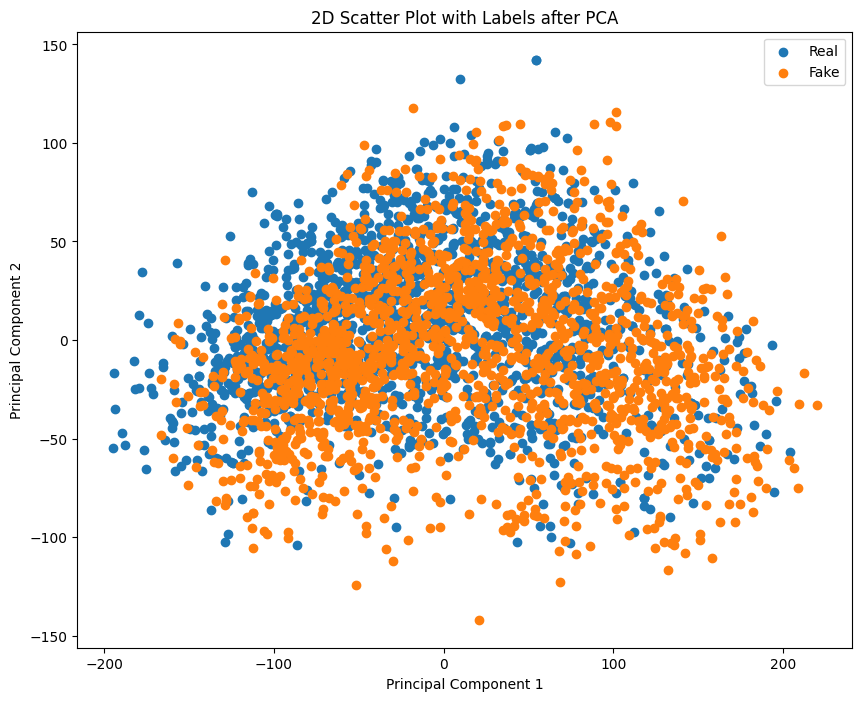

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(X_scaled[np.where(y == 1)[0]][:,0], X_scaled[np.where(y == 1)[0]][:,1], label='Real')
plt.scatter(X_scaled[np.where(y == 0)[0]][:,0], X_scaled[np.where(y == 0)[0]][:,1],  label='Fake')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Scatter Plot with Labels after PCA')
plt.legend()
plt.show();

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


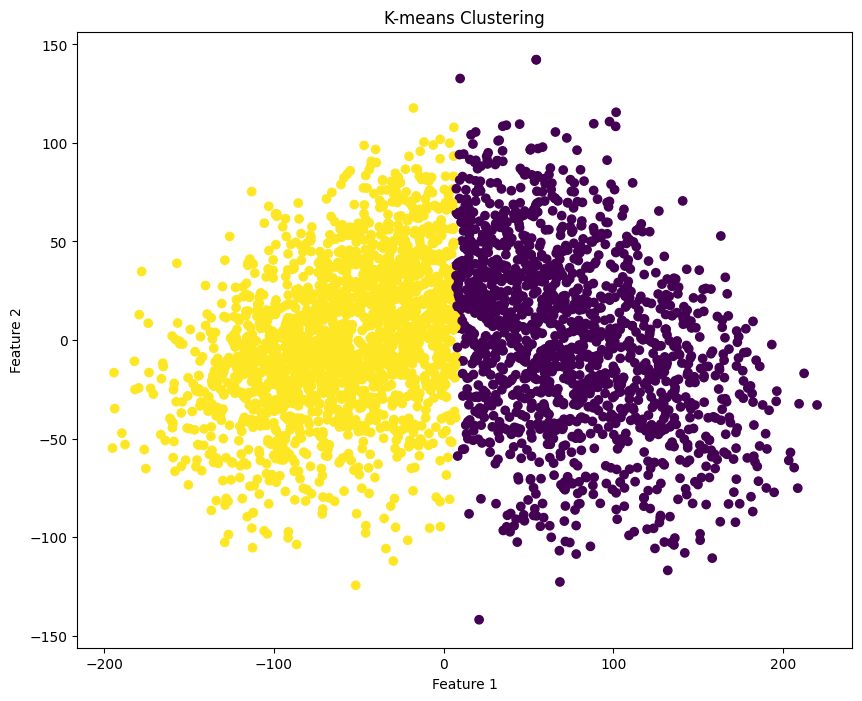

In [34]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
kmeans2 = KMeans(n_clusters=2, random_state=1)
Kmeans2_pred = kmeans2.fit_predict(X_scaled)
plt.figure(figsize=(10, 8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=Kmeans2_pred, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
import umap

reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X_scaled)

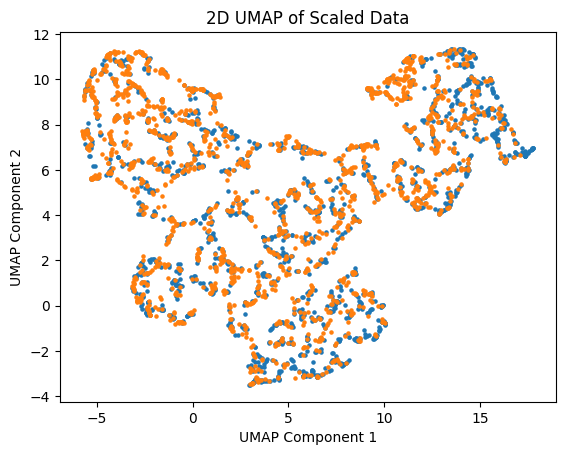

In [37]:
plt.scatter(X_umap[np.where(y == 1)[0]][:,0], X_umap[np.where(y == 1)[0]][:,1], label='Real', s=5)
plt.scatter(X_umap[np.where(y == 0)[0]][:,0], X_umap[np.where(y == 0)[0]][:,1],  label='Fake', s=5)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('2D UMAP of Scaled Data')
plt.show()

# Classification with dimensionality reduction

## LDA

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [14]:
data = np.load('All_Features.npz')
data = data['data']
X_all = data[:, :-1]
y = data[:, -1]

In [15]:
clf_total = LDA()
clf_total.fit(X_all, y)

LinearDiscriminantAnalysis()

In [16]:
X_1D = clf_total.predict(X_all)

In [17]:
X_1D.shape

(3417,)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42)

In [23]:
clf = LDA()
clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [41]:
X_train_reduced = clf.predict(X_train)
X_test_reduced = clf.predict(X_test)

In [42]:
X_train_reduced, X_test_reduced = X_train_reduced.reshape((-1, 1)), X_test_reduced.reshape((-1, 1))

In [26]:
from sklearn.model_selection import GridSearchCV

def grid_search_best_svm(X_train, y_train, cv=10):
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}

    grid = GridSearchCV(svm.SVC(), param_grid, cv=cv, verbose=3)
    grid.fit(X_train, y_train)
    return grid

In [27]:
grid = grid_search_best_svm(X_train_reduced, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.833 total time=   0.1s
[CV 2/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 3/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.791 total time=   0.0s
[CV 4/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.791 total time=   0.1s
[CV 5/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.862 total time=   0.1s
[CV 6/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.816 total time=   0.1s
[CV 7/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.824 total time=   0.0s
[CV 8/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.770 total time=   0.0s
[CV 9/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.749 total time=   0.0s
[CV 10/10] END ......C=0.1, gamma=1, kernel=rbf;, score=0.803 total time=   0.0s
[CV 1/10] END .....C=0.1, gamma=0.1, kernel=rbf;, score=0.833 total time=   0.1s
[CV 2/10] END .....C=0.1, gamma=0.1, kernel=rb

In [28]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=0.1, gamma=1)


In [29]:
print('Train:', '-'*70, sep='\n')
print(classification_report(y_train, grid.predict(X_train_reduced)))
print('Test:', '-'*70, sep='\n')
print(classification_report(y_test, grid.predict(X_test_reduced)))

Train:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81      1220
         1.0       0.79      0.81      0.80      1171

    accuracy                           0.81      2391
   macro avg       0.81      0.81      0.81      2391
weighted avg       0.81      0.81      0.81      2391

Test:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.58      0.61      0.59       490
         1.0       0.62      0.59      0.61       536

    accuracy                           0.60      1026
   macro avg       0.60      0.60      0.60      1026
weighted avg       0.60      0.60      0.60      1026

